# CheXpert Experiment

In [1]:
# Load all necessary packages
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
import os
from utils import ROC
sns.set_theme()

In [2]:
# Load data 
results_dir = 'results/'
data = pd.read_csv('data/results_grouped_condition.csv', index_col=[0])
a_total = np.array(data['Sex'])
y_total = np.array(data['grouped_condition'])
a_hat_total = np.array(data['a_hat'])
y_prob_total = np.array(data['y_prob'])
val_num = len(a_total) - 100000
val_indices = np.random.choice(val_num, size=val_num, replace=False)
y_val = y_total[val_indices]
y_prob_val = y_prob_total[val_indices]

# Determine optimal threshold to get y_hat
thresholds, fprs, tprs = ROC(y_val,y_prob_val)
opt_t = thresholds[np.argmax(np.array(tprs) - np.array(fprs))]

# Create test set
a = np.delete(a_total,val_indices)
y = np.delete(y_total,val_indices)
a_hat = np.delete(a_hat_total,val_indices)
y_prob = np.delete(y_prob_total,val_indices)
y_hat = y_prob >= opt_t

In [3]:
# Run experiment
K = 1000
num_rows = len(a)

d_tpr = []
d_fpr = []
d_tpr_fair = []
d_fpr_fair = []
d_tpr_opt = []
d_fpr_opt = []

b_tpr = []
b_fpr = []
th_b_tpr_fair = []
th_b_fpr_fair = []
ac_b_tpr_fair = []
ac_b_fpr_fair = []
th_b_tpr_opt = []
th_b_fpr_opt = []
ac_b_tpr_opt = []
ac_b_fpr_opt = []

o_loss = []
fair_loss = []
opt_loss = []
k = 0 


while k < K:
    random_indices = np.random.choice(num_rows, size=num_rows, replace=True)
    a_s = a[random_indices]
    y_s = y[random_indices]
    a_hat_s = a_hat[random_indices]
    y_hat_s = y_hat[random_indices]
    true_balancer = BinaryBalancer(y=y_s, y_=y_hat_s, a=a_s, a_hat = a_hat_s, adjusted = False)

    # See if conditions are met
    if true_balancer.assumption == 0:
        true_balancer.adjust(con = 'tpr/fpr', obj = 'none')
        true_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)
    
    # P(Y = 0) and P(Y=1)
    p0 = true_balancer.overall_rates.num_neg
    p1 = true_balancer.overall_rates.num_pos

    # Measure true bias
    d_tpr.append(np.abs(true_balancer.a_gr_list[1].tpr - true_balancer.a_gr_list[0].tpr))
    d_fpr.append(np.abs(true_balancer.a_gr_list[1].fpr - true_balancer.a_gr_list[0].fpr))

    # Calculate worst case fairness violations
    b_tpr.append(np.max([np.abs(true_balancer.bounds['tpr']['ub']), np.abs(true_balancer.bounds['tpr']['lb'])]))
    b_fpr.append(np.max([np.abs(true_balancer.bounds['fpr']['ub']), np.abs(true_balancer.bounds['fpr']['lb'])]))
    o_loss.append(p0*p1*(1 - true_balancer.overall_rates.tpr  + true_balancer.overall_rates.fpr))

    # Adjust by enforcing fairness with respect to A_hat
    true_balancer.adjust(con = 'tpr/fpr', obj = 'fair')
    fair_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_fair.append(np.abs(fair_balancer.a_gr_list[1].tpr - fair_balancer.a_gr_list[0].tpr))
    d_fpr_fair.append(np.abs(fair_balancer.a_gr_list[1].fpr - fair_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_fair.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_fair.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_fair.append(np.max([np.abs(fair_balancer.bounds['tpr']['ub']), np.abs(fair_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_fair.append(np.max([np.abs(fair_balancer.bounds['fpr']['ub']), np.abs(fair_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    fair_loss.append(p0*p1*(1 - fair_balancer.overall_rates.tpr + fair_balancer.overall_rates.fpr))

    # Adjust optimally
    true_balancer.adjust(con = 'tpr/fpr', obj = 'opt')
    opt_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_opt.append(np.abs(opt_balancer.a_gr_list[1].tpr - opt_balancer.a_gr_list[0].tpr))
    d_fpr_opt.append(np.abs(opt_balancer.a_gr_list[1].fpr - opt_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_opt.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_opt.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_opt.append(np.max([np.abs(opt_balancer.bounds['tpr']['ub']), np.abs(opt_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_opt.append(np.max([np.abs(opt_balancer.bounds['fpr']['ub']), np.abs(opt_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    opt_loss.append(p0*p1*(1 - opt_balancer.overall_rates.tpr  + opt_balancer.overall_rates.fpr))

    if k%200 == 0:
        print(k)
    k = k+1 

0
200
400
600
800


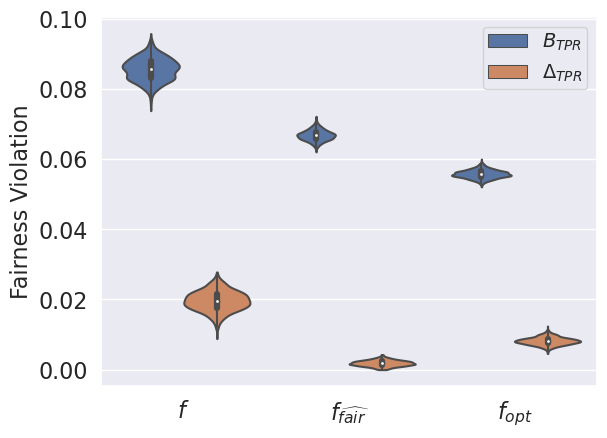

In [6]:
# Plotting theoretical tpr bounds and actual values
iter = K
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + th_b_tpr_fair + th_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.savefig(os.path.join(results_dir, 'theo_b_tpr.pdf'),bbox_inches="tight")

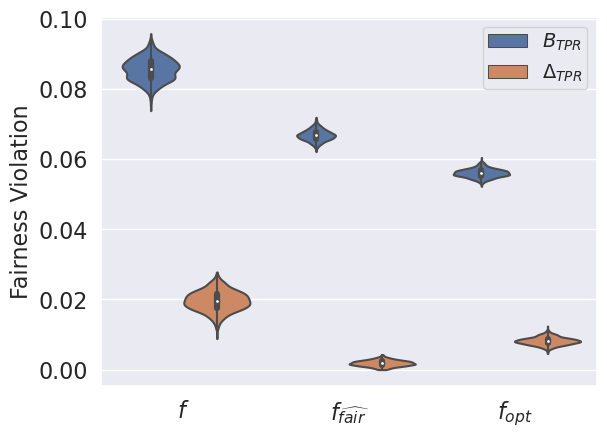

In [7]:
# Plotting actual tpr bounds and actual values
iter = K
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + ac_b_tpr_fair + ac_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.savefig(os.path.join(results_dir, 'ac_b_tpr.pdf'),bbox_inches="tight")

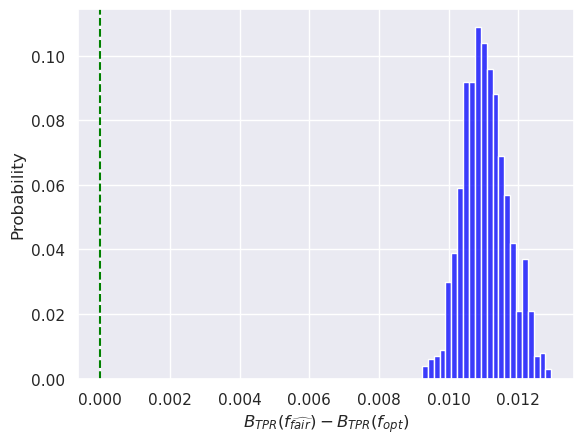

In [8]:
# Difference between theoretical tpr bounds
diff = np.array(th_b_tpr_fair) - np.array(th_b_tpr_opt)
sns.histplot(diff, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{TPR}(f_{\widehat{fair}}) - B_{TPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir, 'b_tpr_diff.pdf'),bbox_inches="tight")

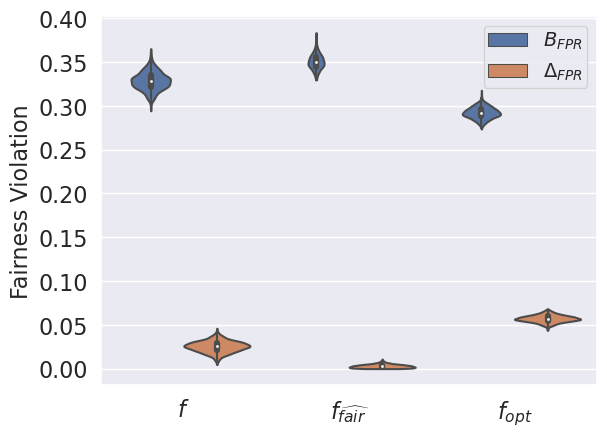

In [9]:
# Plotting theoretical fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + th_b_fpr_fair + th_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_fpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
sns.violinplot(data=b_fpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.savefig(os.path.join(results_dir, 'theo_b_fpr.pdf'),bbox_inches="tight")

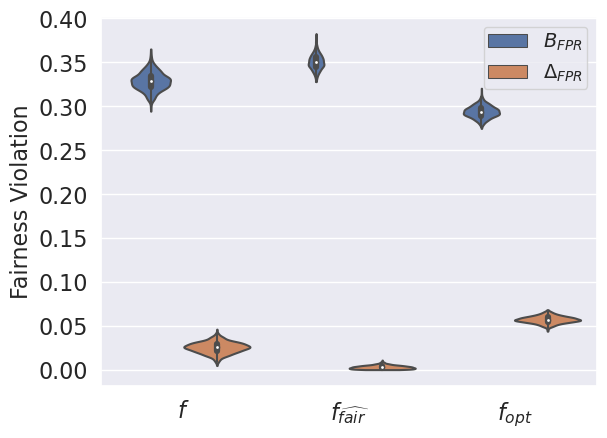

In [10]:
# Plotting theoretical fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + ac_b_fpr_fair + ac_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_fpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
sns.violinplot(data=b_fpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
plt.savefig(os.path.join(results_dir, 'ac_b_fpr.pdf'),bbox_inches="tight")

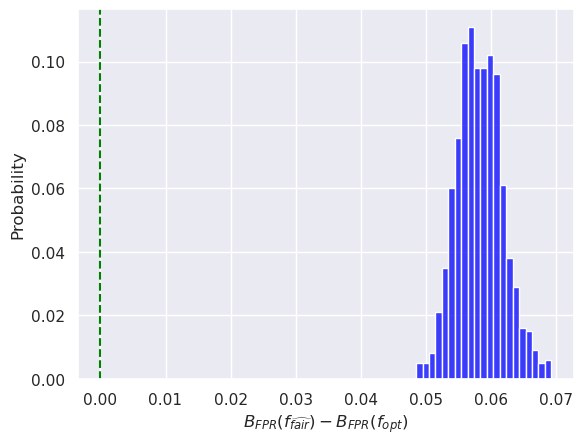

In [11]:
# Difference between theoretical fpr bounds
diff = np.array(th_b_fpr_fair) - np.array(th_b_fpr_opt)
sns.histplot(diff, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{FPR}(f_{\widehat{fair}}) - B_{FPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir, 'b_fpr_diff.pdf'),bbox_inches="tight")

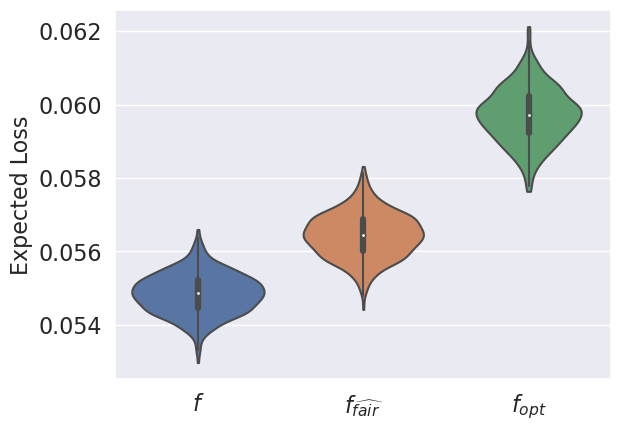

In [12]:
# Plotting expected loss
method =  [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
losses = o_loss + fair_loss + opt_loss
loss_df = pd.DataFrame(list(zip(losses, method)), columns =['Expected Loss', 'Classifier'])
sns.violinplot(data=loss_df, x = 'Classifier', y = 'Expected Loss', cut = 0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Expected Loss', fontsize=16)
plt.savefig(os.path.join(results_dir, 'loss.pdf'),bbox_inches="tight")